In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!nvidia-smi 


Mon Apr 20 21:05:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#Pre-Processing
import os
import re
import torch
import random
import itertools

#Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

# For visualising metrics
# from visdom import Visdom

# For visualising gradients plot
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import copy
import math
import time
from collections import namedtuple, Counter


In [5]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device=torch.device("cpu")
print("The device found: "+str(device))

The device found: cuda


In [0]:
def plot_grad_flow(named_parameters):
    """
        Plotting gradient flow across various layers
        Thanks to: https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/2
    """   
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

# Preprocessing


In [7]:
path='/content/drive/My Drive/Data'
dataset='cornell movie-dialogs corpus'

data_folder=os.path.join(path,dataset)

print("The final data corpus folder: "+str(data_folder))

The final data corpus folder: /content/drive/My Drive/Data/cornell movie-dialogs corpus


In [0]:
def get_lines_conversations():
    """
    Loads movie lines and conversations from the dataset.
    
    data_folder: Destination where conversations and lines are stored.
    
    movie_lines: Consist of movie lines as given by the dataset.
    movie_conversations: Consist of movie conversations as given by the dataset.
    
    """
    movie_lines=[]
    movie_conversations=[]

    with open(os.path.join(data_folder,'movie_lines.txt'),'r',encoding='iso-8859-1') as f:
        for line in f:
            movie_lines.append(line)
    
    with open(os.path.join(data_folder,'movie_conversations.txt'),'r', encoding='iso-8859-1') as f:
        for line in f:
            movie_conversations.append(line)
                                       

    return movie_lines,movie_conversations

In [9]:
t1=time.time()
print("Extracting movie lines and movie conversations...")
movie_lines,movie_conversations=get_lines_conversations()

print("Number of distinct lines: "+str(len(movie_lines)))
print("Number of conversations: "+str(len(movie_conversations)))
print("Average Number of lines per conversations: "+str(len(movie_lines)/len(movie_conversations)))

print(movie_lines[0])
print(movie_conversations[0])

print("Extracting took place in: "+str(time.time()-t1))

Extracting movie lines and movie conversations...
Number of distinct lines: 304713
Number of conversations: 83097
Average Number of lines per conversations: 3.6669554857576085
L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']

Extracting took place in: 4.279463291168213


In [0]:
exceptions=[]
def loadLines(movie_lines,fields):
    lines={}
    for lineid in range(len(movie_lines)):
        
        line=movie_lines[lineid]
        values=line.split(" +++$+++ ")
        
        
        lineVals={}
        
        # print("values"+str(len(values)))
        # print("fields"+str(len(fields)))
              
        for i,field in enumerate(fields):
            try:
                lineVals[field]=values[i]
            except:
                print("Exception: "+str(len(values)))
                exceptions.append(lineid)
        
        lines[lineVals['lineID']]=lineVals
    
    return lines

def loadConversations(movie_conversations,lines,fields):
    conversations=[]
    
    for convo in movie_conversations:
        values=convo.split(" +++$+++ ")
        conVals={}
       
        for i,field in enumerate(fields):
            conVals[field]=values[i]
        
        lineIDs=eval(conVals["utteranceIDs"])
        
        conVals["lines"]=[]
        
        for lineID in lineIDs:
            conVals["lines"].append(lines[lineID])
        conversations.append(conVals)
        
    return conversations

def sentencePairs(conversations):
    qr_pairs=[]
    
    for conversation in conversations:
        for i in range(len(conversation["lines"])-1):
            query=conversation["lines"][i]["text"].strip()
            response=conversation["lines"][i+1]["text"].strip()
            
            if query and response:
                qr_pairs.append([query,response])
        
    return qr_pairs

In [11]:
t1=time.time()
print("Separating meaningfull information for our model...")

lines={}
conversations=[]
qr_pairs=[]

movie_lines_fields=["lineID","characterID","movieID","character","text"]
movie_convo_fields=["charcaterID","character2ID","movieID","utteranceIDs"]

lines=loadLines(movie_lines,movie_lines_fields)
conversations=loadConversations(movie_conversations,lines,movie_convo_fields)
qr_pairs=sentencePairs(conversations)

print("The number of query-response pairs are: "+str(len(qr_pairs)))
print("Separation took place in: "+str(time.time()-t1))

Separating meaningfull information for our model...
The number of query-response pairs are: 221282
Separation took place in: 1.991434097290039


In [0]:
PAD_Token=0
START_Token=1
END_Token=2

class Vocabulary:
    def __init__(self):
        self.trimmed=False
        self.word2count={}
        self.index2word={PAD_Token:"PAD",START_Token:"SOS",END_Token:"EOS"}
        self.word2index={"PAD":PAD_Token,"SOS":START_Token,"EOS":END_Token}
        self.num_words=3
        
    def addSentence(self,sentence):
        for word in sentence.split(" "):
            self.addWord(word)
    def addWord(self,word):
        if word not in self.word2index:
            self.word2index[word]=self.num_words
            self.index2word[self.num_words]=word
            self.word2count[word]=1
            self.num_words=self.num_words+1
        else:
            self.word2count[word]+=1
            
    def trim(self,min_count):
        
        if self.trimmed:
            return
        self.trimmed=True
        
        keep_words=[]
        
        for word,freq in self.word2count.items():
            if freq>=min_count:
                keep_words.append(word)
        
        self.word2count={}
        self.index2word={PAD_Token:"PAD",START_Token:"SOS",END_Token:"EOS"}
        self.word2index={"PAD":PAD_Token,"SOS":START_Token,"EOS":END_Token}
        self.num_words=3
        
        for word in keep_words:
            self.addWord(word)

In [13]:
Max_Length=10

def normalizeString(s):
    s=s.lower().strip()
    s=re.sub(r"([.!?])", r" \1", s)
    s=re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s=re.sub(r"\s+", r" ", s).strip()
    return s

def readVocs(qr_pairs):
    
    for qr_pair in qr_pairs:
        qr_pair[0]=normalizeString(qr_pair[0])
        qr_pair[1]=normalizeString(qr_pair[1])
    
    voc=Vocabulary()
    return voc,qr_pairs

def filterPair(pair):
    return len(pair[0].split(" "))<Max_Length and len(pair[1].split(" "))<Max_Length

def filterPairs(qr_pairs):
    return [pair for pair in qr_pairs if filterPair(pair)]

def prepareDataset(qr_pairs):
    voc, qr_pairs=readVocs(qr_pairs)
    qr_pairs=filterPairs(qr_pairs)
       
    for pair in qr_pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
#     print("Number"+str(voc.num_words))
    return voc,qr_pairs

t1=time.time()
print("Preparing dataset and corresponding vocabulary...")
voc, pairs=prepareDataset(qr_pairs)
print("Preparation took place in: "+str(time.time()-t1))

Preparing dataset and corresponding vocabulary...
Preparation took place in: 5.845985412597656


In [14]:
Min_Count=3

def trimRareWords(voc,qr_pairs):
    
    voc.trim(Min_Count)
    keep_pairs=[]
    
    for pair in qr_pairs:
        input_sentence=pair[0]
        output_sentence=pair[1]
        
        keep_input=True
        keep_output=True
        
        for word in input_sentence.split(" "):
            if word not in voc.word2index:
                keep_input=False
                break
        
        for word in output_sentence.split(" "):
            if word not in voc.word2index:
                keep_output=False
                break
                
        if keep_input and keep_output:
            keep_pairs.append(pair)
            
    return keep_pairs

t1=time.time()
print("Trimming rare words from vocabulary and dataset..")

pairs=trimRareWords(voc,pairs)

print("Trimming took place in: "+str(time.time()-t1))

Trimming rare words from vocabulary and dataset..
Trimming took place in: 0.1217508316040039


In [0]:
# def indexesFromSentence(voc,sentence):
#     tokenised_sentence=[]
#     tokenised_sentence.append(START_Token)
    
#     for word in sentence.split(" "):
#         tokenised_sentence.append(voc.word2index[word])
        
#     tokenised_sentence.append(END_Token)
    
#     assert len(tokenised_sentence)<=Max_Length+2
#     for _ in range(Max_Length+2-len(tokenised_sentence)):
#         tokenised_sentence.append(PAD_Token)
        
#     return tokenised_sentence

# def binaryMatrix(l,value=PAD_Token):
#     m=[]
#     for i,seq in enumerate(l):
#         m.append([])
#         for token in seq:
#             if token==value:
#                 m[i].append(0)
#             else:
#                 m[i].append(1)
        
#     return m

# def inputVar(voc,l):
    
#     indexes_batch=[indexesFromSentence(voc,sentence) for sentence in l]
#     input_lengths=torch.tensor([len(index) for index in indexes_batch])
#     padVar=torch.LongTensor(indexes_batch)
#     return input_lengths,padVar

# def outputVar(voc,l):
#     indexes_batch=[indexesFromSentence(voc,sentence) for sentence in l]
#     max_target_len=torch.tensor([len(index) for index in indexes_batch])
#     mask=binaryMatrix(indexes_batch)
#     mask=torch.ByteTensor(mask)
#     padVar=torch.LongTensor(indexes_batch)
#     return max_target_len, mask, padVar

# def batch2TrainData(voc,pair_batch):
#     #sort function see 
#     input_batch=[]
#     output_batch=[]

#     for pair in pair_batch:
#         input_batch.append(pair[0])
#         output_batch.append(pair[1])
                                  
    
#     input_lengths,tokenised_input=inputVar(voc,input_batch)
#     max_out_length,mask,tokenised_output=outputVar(voc,output_batch)
#     return input_lengths,tokenised_input,max_out_length,mask,tokenised_output

def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [END_Token]


def zeroPadding(l, fillvalue=PAD_Token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_Token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_Token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


In [16]:
print("Number of query-response pairs after all the preprocessing: "+str(len(pairs)))

#Sample batch
batch=[random.choice(pairs) for _ in range(5)]
tokenised_input,input_lengths,tokenised_output,mask,max_out_length=batch2TrainData(voc,batch)

print("Input length: "+str(input_lengths)+" Size: "+str(input_lengths.shape))
print("-"*80)
print("Tokenised Input: "+str(tokenised_input)+" Size: "+str(tokenised_input.shape))
print("-"*80)
print("Max out length: "+str(max_out_length)+" Size: ")
print("-"*80)
print("Mask: "+str(mask)+" Size: "+str(mask.shape))
print("-"*80)
print("Tokenised Output: "+str(tokenised_output)+" Size: "+str(tokenised_output.shape))
print("-"*80)

Number of query-response pairs after all the preprocessing: 53113
Input length: tensor([10,  7,  7,  6,  3]) Size: torch.Size([5])
--------------------------------------------------------------------------------
Tokenised Input: tensor([[ 115,   27,    5,  101,   50],
        [  36,  354,   68,   37,    6],
        [ 100,    8,    7,   12,    2],
        [7284,   40,  359, 1506,    0],
        [ 247,   60,   36,    4,    0],
        [ 117,    6,    6,    2,    0],
        [ 141,    2,    2,    0,    0],
        [  83,    0,    0,    0,    0],
        [   6,    0,    0,    0,    0],
        [   2,    0,    0,    0,    0]]) Size: torch.Size([10, 5])
--------------------------------------------------------------------------------
Max out length: 9 Size: 
--------------------------------------------------------------------------------
Mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True, 

# Model

In [0]:
class EncoderRNN(nn.Module):
    
    def __init__(self,hidden_size,embedding,n_layers=1,dropout=0):
        """
        Encoder module for seq2seq architechture.
        """
    
        super().__init__()
        
        self.n_layers=n_layers
        self.hidden_size=hidden_size
        
        self.embedding=embedding
        self.gru=nn.GRU(hidden_size,hidden_size,n_layers,dropout=(0 if n_layers==1 else dropout),bidirectional=True)
        
    def forward(self,input_seq,input_lengths,hidden=None):
        
        embedded_input=self.embedding(input_seq)
        packed=nn.utils.rnn.pack_padded_sequence(embedded_input,input_lengths)
        outputs,hidden=self.gru(packed,hidden)
        
        outputs,_=nn.utils.rnn.pad_packed_sequence(outputs)
        
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        
        return outputs,hidden

    def hidden_init(self,batch_size):
        return torch.zeros(self.n_layers*2,batch_size,self.hidden_size,device=device)


In [0]:
# Luong attention layer
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = torch.nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = torch.nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = torch.nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [0]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        
        rnn_output, hidden = self.gru(embedded, last_hidden)
        
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        # output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
def make_model(vocabulary_size,d_model=500,num_encoders=1,num_decoders=1,dropout_encoder=0.1,dropout_decoder=0.1,attn_model='general'):

    embedding=nn.Embedding(vocabulary_size,d_model)
    embedding.weight.requires_grad=False

    encoder=EncoderRNN(d_model,embedding,num_encoders,dropout_encoder)
    decoder=LuongAttnDecoderRNN(attn_model,embedding,d_model,vocabulary_size,num_decoders,dropout_decoder)

    for p in encoder.parameters():
        if p.dim()>1:
            nn.init.xavier_uniform_(p)
    
    for p in decoder.parameters():
        if p.dim()>1:
            nn.init.xavier_uniform_(p)
    
    num_parameters=0

    num_parameters+=count_parameters(encoder)
    num_parameters+=count_parameters(decoder)

    return encoder,decoder,num_parameters



# Training

In [0]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [0]:
def f1_score(predictions, targets, average=True):
    def f1_score_items(pred_items, gold_items):
        common = Counter(gold_items) & Counter(pred_items)
        num_same = sum(common.values())

        if num_same == 0:
            return 0

        precision = num_same / len(pred_items)
        recall = num_same / len(gold_items)
        f1 = (2 * precision * recall) / (precision + recall)

        return f1
    
    scores = [f1_score_items(p, t) for p, t in zip(predictions, targets)]

    if average:
        return sum(scores) / len(scores)    

    return scores

In [0]:

MAX_LENGTH=10
def train(input_variable,lengths,target_variable,mask,max_target_len,encoder,decoder,
          encoder_optimizer,decoder_optimizer,batch_size,clip,max_length=MAX_LENGTH):
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    loss_fn=nn.CrossEntropyLoss()
    
    input_variable=torch.tensor(input_variable).to(device)
    lengths=lengths.to(device)

    target_variable=torch.tensor(target_variable).to(device)
    mask=mask.to(device)
    
    loss=0
    print_losses=[]
    n_totals=0
    encoder_hidden=encoder.hidden_init(input_variable.size()[1])
    encoder_outputs, encoder_hidden=encoder(input_variable,lengths,encoder_hidden)
    
    decoder_input=torch.LongTensor([[START_Token for _ in range(batch_size)]])
    decoder_input=decoder_input.to(device)
    use_teacher_forcing=True #if random.random()<teacher_forcing_ratio else False
    
    decoder_hidden=encoder_hidden[:decoder.n_layers]

    predicted=torch.ones(max_target_len,input_variable.size()[1])
    
    if use_teacher_forcing:
        
        for t in range(max_target_len):
            decoder_output,decoder_hidden=decoder(decoder_input,decoder_hidden,encoder_outputs)
            
            decoder_input=target_variable[t].view(1,-1)
            
            
            # mask_loss=F.cross_entropy(decoder_output,target_variable[t])
            # mask_loss,nTotal=maskNLLLoss(decoder_output,target_variable[t],mask)
            mask_loss=loss_fn(decoder_output,target_variable[t])
            loss+=mask_loss
            nTotal=(mask.sum()).item()
            print_losses.append(mask_loss.item()*nTotal)
            n_totals+=nTotal
            predicted[t]=torch.argmax(decoder_output,dim=-1)
            

            
    # else:
        
    #     for t in range(max_target_len):
    #         decoder_output,decoder_hidden=decoder(decoder_input,decoder_hidden,encoder_outputs)
            
    #         _,topi=decoder_output.topk(1)
    #         decoder_input=torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
    #         decoder_input=decoder_input.to(device)
            
    #         mask_loss,nTotal=maskNLLLoss(decoder_output,target_variable[t],mask[t])
    #         loss+=mask_loss
    #         print_losses.append(mask_loss.item()*nTotal)
    #         n_totals+=nTotal
            
    F1=f1_score(predicted,target_variable.transpose(0,1))
    loss.backward()
    
    # _=nn.utils.clip_grad_norm_(encoder.parameters(),clip)
    # _=nn.utils.clip_grad_norm_(decoder.parameters(),clip)
    
    
    # plot_grad_flow(encoder.named_parameters())
    # plot_grad_flow(decoder.named_parameters())
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return sum(print_losses)/n_totals,F1
    


In [0]:
def trainIters(model_name,voc,pairs,encoder,decoder,encoder_optimizer,decoder_optimizer,
               encoder_n_layers,decoder_n_layers,save_dir,n_batches,batch_size,
               save_every,clip,corpus_name,loadFileName,n_epochs):
    
    training_batches=[batch2TrainData(voc,[random.choice(pairs) for _ in range(batch_size)]) for _ in range(n_batches)]
    
    start_epoch=0
    loss=0
    perplexity=0
    time_taken=0
    f1_score=0
    
    if loadFileName:
        start_epoch=checkpoint['epoch']+1
        time_taken=checkpoint['time']
        
        
    for epoch in range(start_epoch,n_epochs):

        t1=time.time()
        loss=0
        perplexity=0
        f1_score=0

        for i in range(n_batches):
            
            training_batch=training_batches[i]
            
            input_variable,lengths,target_variable,mask,max_target_len=training_batch

            curr_loss,F1=train(input_variable,lengths,target_variable,mask,max_target_len,encoder,decoder,
                    encoder_optimizer,decoder_optimizer,batch_size,clip)
            
            loss+=curr_loss
            perplexity+=math.exp(curr_loss)
            f1_score+=F1
            
        
        
        loss=loss/n_batches
        perplexity=perplexity/n_batches
        f1_score=f1_score/n_batches

        
        
        
        
        
        if epoch%save_every==0:

            directory=os.path.join(save_dir,model_name,corpus_name)
            if not os.path.exists(directory):
                os.makedirs(directory)
            
            torch.save({
                "epoch":epoch,
                "encoder":encoder.state_dict(),
                "decoder":decoder.state_dict(),
                "loss":loss,
                "encoder_opt":encoder_optimizer.state_dict(),
                "decoder_opt":decoder_optimizer.state_dict(),
                "ppl":perplexity,
                "time":time_taken,
                "F1":f1_score

            },os.path.join(directory,'{}_{}.tar'.format(epoch,"checkpoint")))
        
        print("="*100)
        print("| End of epoch : "+str(epoch)+"| Loss Value: "+str(loss)+"| PPL: "+str(perplexity)+"| F1: "+str(f1_score)+"| Time Took: "+
            str(time.time()-t1)+" |")
        print("="*100)
        time_taken+=(time.time()-t1)

    print("| Training Finished | Took:"+str(time_taken))          
        

        

        

In [0]:
model_name='seq2seq_attn'
corpus_name='cornell-movie'

attn_model='dot'
num_encoder=2
num_decoder=2
d_model=500
dropout_encoder=0.1
dropout_decoder=0.1

batch_size=10
n_batches=4000

clip=50.0
teacher_forcing_ratio=1.0
learning_rate=0.0001
decoder_learning_ratio=5.0


save_every=10
n_epochs=101

loadFile=None

save_dir="/content/drive/My Drive/Model Data"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


KeyboardInterrupt: ignored

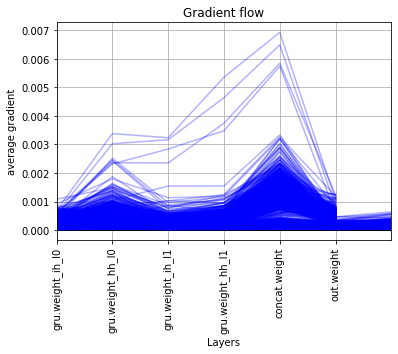

In [110]:

encoder,decoder,num_parameters=make_model(voc.num_words,d_model,num_encoder,num_decoder,dropout_encoder,dropout_decoder,attn_model)

encoder_optimizer=torch.optim.Adam(encoder.parameters(),lr=learning_rate)
decoder_optimizer=torch.optim.Adam(decoder.parameters(),lr=learning_rate*decoder_learning_ratio)

if loadFile:
    checkpoint=torch.load(loadFile)

    encoder.load_state_dict(checkpoint['encoder'])
    decoder.load_state_dict(checkpoint['decoder'])
    encoder_optimizer.load_state_dict(checkpoint['encoder_opt'])
    decoder_optimizer.load_state_dict(checkpoint['decoder_opt'])



encoder.to(device)
decoder.to(device)

encoder.train()
decoder.train()

trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
        num_encoder, num_decoder, save_dir, n_batches, batch_size, save_every, clip, corpus_name, loadFile,n_epochs)



In [38]:
inp=torch.randn(3,5,requires_grad=True)
target=torch.randint(5,(3,),dtype=torch.int64)
print(target.size())
loss=F.cross_entropy(inp,target)


torch.Size([3])


In [0]:
for p in encoder.named_parameters():
    print(p)

('embedding.weight', Parameter containing:
tensor([[-0.0169,  0.0251,  0.0204,  ...,  0.0075,  0.0139,  0.0120],
        [ 0.0124,  0.0165,  0.0065,  ..., -0.0221,  0.0064,  0.0141],
        [-0.0076,  0.0232, -0.0088,  ...,  0.0180,  0.0148,  0.0076],
        ...,
        [-0.0122,  0.0191,  0.0154,  ..., -0.0023, -0.0032, -0.0015],
        [-0.0190,  0.0204,  0.0163,  ...,  0.0105, -0.0007, -0.0261],
        [ 0.0197,  0.0206, -0.0006,  ..., -0.0121,  0.0172,  0.0114]],
       device='cuda:0'))
('gru.weight_ih_l0', Parameter containing:
tensor([[-0.0411, -0.0188, -0.0036,  ..., -0.0146, -0.0212,  0.0180],
        [ 0.0507,  0.0262, -0.0105,  ..., -0.0385,  0.0167, -0.0551],
        [ 0.0147,  0.0347,  0.0093,  ..., -0.0529,  0.0524,  0.0382],
        ...,
        [-0.0365, -0.0202,  0.0214,  ...,  0.0426, -0.0402, -0.0249],
        [-0.0012,  0.0068,  0.0317,  ..., -0.0310, -0.0315,  0.0405],
        [-0.0432,  0.0164, -0.0080,  ...,  0.0012,  0.0052, -0.0178]],
       device='cuda:0

In [0]:
class GreedySearchDecoder(nn.Module):
    
    def __init__(self,encoder,decoder):
        super().__init__()
        
        self.encoder=encoder
        self.decoder=decoder
        
    def forward(self,input_seq,input_length,max_length):
        
        encoder_outputs,encoder_hidden=self.encoder(input_seq,input_length)
        
        decoder_hidden=encoder_hidden[:decoder.n_layers]
#         print("Decoder hidden state: "+str(decoder_hidden))
        decoder_input=torch.ones(1,1,device=device,dtype=torch.long)*START_Token
        
        
#         print("Decoder's Input: "+str(decoder_input))
        all_tokens=torch.zeros([0],device=device,dtype=torch.long)
        all_scores=torch.zeros([0],device=device)
        
        for _ in range(max_length):
            
            decoder_output,decoder_hidden=self.decoder(decoder_input,decoder_hidden,encoder_outputs)
#             print("Decoder Output: "+str(decoder_output))
            decoder_scores,decoder_input=torch.max(decoder_output,dim=1)
            all_scores=torch.cat((all_scores,decoder_scores),dim=0)
            all_tokens=torch.cat((all_tokens,decoder_input),dim=0)
            
            decoder_input=torch.unsqueeze(decoder_input,0)
            
        return all_tokens, all_scores
        
        

In [0]:
def evaluate(encoder, decoder, searcher,voc,sentence,max_length=MAX_LENGTH):
    
    index_batch=[indexesFromSentence(voc,sentence)]
#     print("Indexed sentence: "+str(index_batch))
    lengths=torch.tensor([len(index) for index in index_batch])
#     print("The Lengths tensor: "+str(lengths))
    input_batch=torch.LongTensor(index_batch).transpose(0,1)
    
    input_batch=input_batch.to(device)
    lengths=lengths.to(device)
    
    tokens, scores=searcher(input_batch,lengths,max_length)
#     print("The tokens: "+str(tokens))
    decoded_words=[voc.index2word[token.item()] for token in tokens]
    return decoded_words

def evaluateInput(encoder,decoder,searcher,voc):
    input_sentence=''
    while True:
        try:
            input_sentence=input('Human> ')
            
            if input_sentence=='q' or input_sentence=='quit':
                break
            input_sentence=normalizeString(input_sentence)
#             print("The Normalized Input Sentence: "+str(input_sentence))
            output_words=evaluate(encoder,decoder,searcher,voc,input_sentence)
            
            output_words[:]=[x for x in output_words if not(x=="PAD" or x=="EOS")]
            print("Bot:"," ".join(output_words))
            
        except KeyError:
            print("Unknown Word")
            
            
    

In [0]:
encoder.eval()
decoder.eval()

LuongAttnDecoderRNN(
  (embedding): Embedding(7816, 500)
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(500, 500, num_layers=2, dropout=0.1)
  (concat): Linear(in_features=1000, out_features=500, bias=True)
  (out): Linear(in_features=500, out_features=7816, bias=True)
  (attn): Attn()
)

In [0]:
searcher=GreedySearchDecoder(encoder,decoder)
evaluateInput(encoder,decoder,searcher,voc)

Human> hello
Bot: hi . to go . .
Human> goodbye
Bot: you re not a good idea . .
Human> how do you do
Bot: i m not going to be . .
Human> what do you do
Bot: i m not going to be . .
Human> where do you live
Bot: i m not going to be .
Human> what are you daying
Unknown Word
Human> who are you
Bot: i m not going to be . .


KeyboardInterrupt: ignored